# EXPLORATION 10.뉴스 요약봇 만들기

## 1. 데이터 불러오기

In [45]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
data.sample(10)

,headlines,text
88924,Pak set all fielders close to batsman for reco...,Pakistan captain Misbah-ul-Haq placed all fiel...
74162,Woman survives after being tossed in the air b...,A 30-year-old woman has survived an accident a...
42963,Climate change could create 14 crore migrants:...,"More than 14 crore people across south Asia, s..."
84503,Rambo remake director reveals why Hrithik didn...,Director Siddharth Anand has revealed that Hri...
34136,Cricket Aus trolled for sharing video of Sachi...,On the occasion of Sachin Tendulkar and Damien...
13656,Will work in balanced way to protect human rig...,After India was elected to UN Human Rights Cou...
31566,Heartbreaking that my sons don't play football...,Former England and Manchester United captain D...
7964,Indian maid jailed in Singapore for training 1...,A 33-year-old Indian woman working as a maid i...
29805,What all is Meghan Markle not allowed to do as...,"After marrying UK's Prince Harry, former actre..."
47712,Afridi reveals why he asked Indian fan to stra...,Shahid Afridi has revealed he asked an Indian ...


In [47]:
print(len(data)) # 전체 데이터 갯수
print(data['text'].nunique()) # text 컬럼 중복 제거 수
print(data['headlines'].nunique()) # headlines 컬럼 중복 제거 수
data.drop_duplicates(subset = ['headlines'],inplace=True) # 중복 샘플 제거
data.drop_duplicates(subset = ['text'],inplace=True) # 중복 샘플 제거

98401
98360
98280


In [48]:
print(len(data))
print(data.isnull().sum()) # Null 값 없음

98262
headlines    0
text         0
dtype: int64


## 2. 텍스트 정규화와 불용어 제거

In [49]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print(f"정규화 사전의 수: {len(contractions)}")
print('불용어 개수 :',len(stopwords.words('english')))

정규화 사전의 수: 120
불용어 개수 : 179


## 3. 데이터 전처리

In [50]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

## 3-1 멀티프로세싱으로 데이터 전처리

In [51]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

585.5785958766937  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

## 3-2 훈련데이터 및 테스트데이터 나누기

In [52]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [53]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


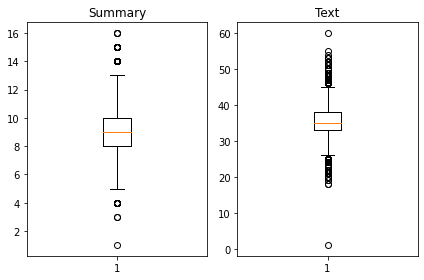

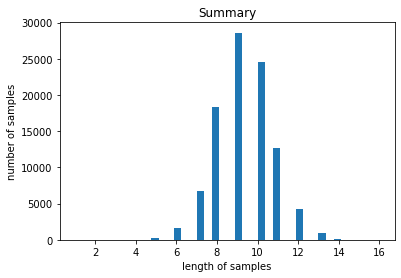

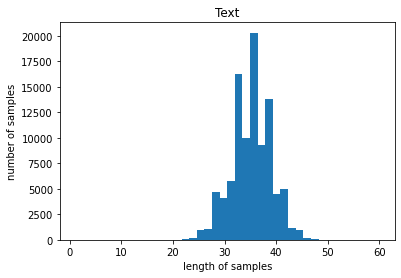

In [54]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [55]:
text_max_len = 37
headlines_max_len = 10

In [56]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [57]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7377419551810466
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.816317599886019


In [58]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 58848


## 3-3 시작 토큰과 종료 토큰 추가하기

In [59]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

In [60]:
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
16,karan johar tabu turn showstoppers on opening ...,filmmaker karan johar actress tabu turned show...,sostoken karan johar tabu turn showstoppers on...,karan johar tabu turn showstoppers on opening ...


In [61]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [62]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[48742 14494 48929 ... 11841 57824 24563]


In [63]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [64]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 11769


In [65]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 47079
훈련 레이블의 개수 : 47079
테스트 데이터의 개수 : 11769
테스트 레이블의 개수 : 11769


## 3-4 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [66]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [67]:
def frequency(tokens):
    threshold=4
    total_cnt = len(tokens.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokens.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

frequency(src_tokenizer)

단어 집합(vocabulary)의 크기 : 54247
등장 빈도가 3번 이하인 희귀 단어의 수: 31398
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22849
단어 집합에서 희귀 단어의 비율: 57.87969841650229
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0061737323294992


In [68]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [69]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [70]:
print(encoder_input_test[:3])

[[5540, 144, 3187, 4070, 5282, 5859, 2, 14, 1215, 1627, 2539, 1926, 4602, 5847, 6629, 550, 52, 4070, 1405, 160, 2539, 7526, 2223, 542, 544, 476, 6024, 283, 522, 144, 3069], [4636, 1544, 132, 56, 3797, 44, 1108, 1177, 915, 1444, 1418, 637, 50, 632, 2368, 2335, 3831, 108, 1306, 429, 203, 7223, 1016, 1418, 384], [655, 208, 431, 1192, 450, 66, 1612, 1210, 75, 410, 698, 6710, 91, 1975, 1190, 1621, 3604, 125, 289, 8, 392, 5, 249, 6367, 263]]


In [71]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [72]:
frequency(tar_tokenizer)

단어 집합(vocabulary)의 크기 : 24750
등장 빈도가 3번 이하인 희귀 단어의 수: 14591
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10159
단어 집합에서 희귀 단어의 비율: 58.95353535353536
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.771385952396394


In [73]:
tar_tokenizer = Tokenizer(num_words=2000)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 528, 942, 388, 474, 5, 3, 209, 32, 210], [1, 1642, 1485, 13, 85, 5, 696], [1, 125, 911, 1051, 1643, 389, 113, 173], [1, 1644, 127, 9, 571, 282], [1, 30, 67, 769, 3, 58, 536, 427, 36, 532]]
target
decoder  [[528, 942, 388, 474, 5, 3, 209, 32, 210, 2], [1642, 1485, 13, 85, 5, 696, 2], [125, 911, 1051, 1643, 389, 113, 173, 2], [1644, 127, 9, 571, 282, 2], [30, 67, 769, 3, 58, 536, 427, 36, 532, 2]]


In [74]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 8
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 47071
훈련 레이블의 개수 : 47071
테스트 데이터의 개수 : 11767
테스트 레이블의 개수 : 11767


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [75]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3-5. 어텐션 메커니즘 사용하기 (추상적 요약)

In [76]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(8000, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [77]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(2000, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [78]:
# 디코더의 출력층
decoder_softmax_layer = Dense(2000, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 37, 128)      1024000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 37, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [79]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [80]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(2000, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 37, 128)      1024000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 37, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [81]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
184/184 [==============================] - 213s 1s/step - loss: 4.8675 - val_loss: 4.1631
Epoch 2/50
184/184 [==============================] - 191s 1s/step - loss: 4.1381 - val_loss: 3.9466
Epoch 3/50
184/184 [==============================] - 195s 1s/step - loss: 3.8874 - val_loss: 3.6987
Epoch 4/50
184/184 [==============================] - 194s 1s/step - loss: 3.6550 - val_loss: 3.5380
Epoch 5/50
184/184 [==============================] - 194s 1s/step - loss: 3.4679 - val_loss: 3.4071
Epoch 6/50
184/184 [==============================] - 193s 1s/step - loss: 3.3244 - val_loss: 3.3131
Epoch 7/50
184/184 [==============================] - 195s 1s/step - loss: 3.2020 - val_loss: 3.2337
Epoch 8/50
184/184 [==============================] - 193s 1s/step - loss: 3.0904 - val_loss: 3.1808
Epoch 9/50
184/184 [==============================] - 151s 822ms/step - loss: 2.9993 - val_loss: 3.1296
Epoch 10/50
184/184 [==============================] - 118s 639ms/step - loss: 2.9141 - 

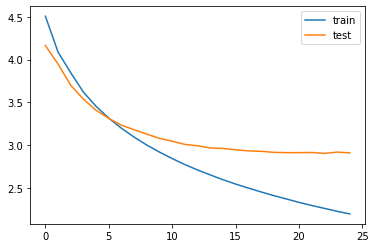

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [83]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [84]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [85]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [90]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [87]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [91]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : directorate general civil aviation told national green tribunal impossible dump human aircraft toilets comes days dgca issued circular compliance directions ngt stating airlines pay found dumping toilet waste mid air dgca also sought review stay order 
실제 요약 : to mid air tells ngt 
예측 요약 :  ministry panel to put on emergency


원문 : delhi cm arvind kejriwal leave maharashtra september attend day session centre cm access outdoor media including newspapers television period official said notably ancient technique includes strict discipline giving luxury among others 
실제 요약 : delhi cm kejriwal to attend day session in maha 
예측 요약 :  will not be in delhi cm kejriwal


원문 : four students seven years age washed away krishna river andhra pradesh district wednesday morning said police inspector locals immediately jumped water save since flow swift could catch boys added 
실제 요약 : four students away in river in andhra 
예측 요약 :  students die after river in andhra pradesh


원문 : ahead champion

## 5. 추출적 요약

In [93]:
import requests
from summa.summarizer import summarize

In [94]:
data_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('Summary:')
print(summarize(data_news["text"][i], ratio=0.5, split=True))

Summary:
['He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".']


In [95]:
print('Summary:')
print(summarize(data_news["text"][i], words=50))

Summary:
Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth.
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


### 회고 : 처음 어텐션을 코드로 구현해서 NLP에 적용하는 기준이 정말 색달랐습니다.. 아무래도 처음 요약을 실행해서 정리를 하였는데 인코더 및 디코더에 입력 출력층에 관련해서 조금 더 이해도를 높힐 수 있었던 계기가 되었습니다..아직까지 이해가 안된 부분들이 정말 너무나도 많지만 천천히 공부할려고 합니다.. 문장은 제 기준에선 어느정도 납득가게 나온 것 같아서 그나마 만족스럽게 제출할 수 있었던 것 같습니다